<a href="https://colab.research.google.com/github/areegtarek/Predicting-Stock-Price-Movement-from-Earnings-Call-Transcripts/blob/main/Stock_Price_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Stock Price Movement from Earnings Call Transcripts**

The goal of this project is to fine-tune a BERT NLP model to predict if a company's stock price will increase or decrease in the following quarter based on the text from their earnings call transcript.

To begin, we do not have labeled data directly relating earnings call text to subsequent stock price movement. Therefore, as an initial step we will leverage the output of an existing sentiment analysis model based on BERT to generate noisy labels for our data.

If the sentiment is positive, label the data as "increase"
If the sentiment is negative, label the data as "decrease"
This will give us an initial (albeit noisy) labeled dataset to work with for the next phase of fine-tuning.

**Sentiment Analysis Repo:** https://github.com/areegtarek/Sentiment-Analysis-of-Earnings-Call-Transcripts-using-BERT/tree/main

Next, we will fine-tune a BERT model on the hand-generated labeled earnings call dataset to directly predict stock price movement. We will evaluate the fine-tuned model on a held-out test set to measure its accuracy at predicting increases vs decreases relative to the actual stock performance in subsequent quarters.

The goal of this approach is to leverage transfer learning from pretrained BERT models to build an initial predictor, and then fine-tune the model directly on our domain of interest. This two-step process helps address the lack of direct labeling for our desired prediction task.

**1. What is BERT?**

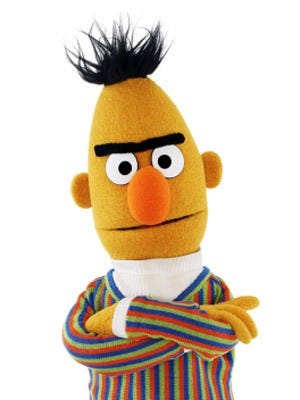

**BERT is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It stands for Bidirectional Encoder Representations for Transformers. It has been pre-trained on Wikipedia and BooksCorpus and requires task-specific fine-tuning**

**2. Why BERT?**

* BERT was built upon recent work and clever ideas in pre-training contextual representations including Semi-supervised Sequence Learning, Generative Pre-Training, ELMo, the OpenAI Transformer, ULMFit and the Transformer. Although these models are all unidirectional or shallowly bidirectional, BERT is fully bidirectional.
* BERT gives it incredible accuracy and performance on smaller data sets which solves a huge problem in natural language processing.

**3. How does it work?**

BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

1. Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2. Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
3. Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

**4. How to use BERT?**

**BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model**

1. Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.

2. In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.

3. In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.

# **Import Libraries and Data**

In [1]:
pip install transformers

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import itertools
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
from datetime import datetime

In [48]:
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
pd.set_option("max_colwidth", 100)

In [12]:
df1= pd.read_csv('data/stock_price.csv')
df2= pd.read_csv('data/full_sample.csv')

In [18]:
df1.head(1)

,Unnamed: 0,transcript,Positive,Negative,Neutral
0,0,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",0.383404,0.02244,0.594157


In [20]:
df1['transcript'][0]

'\'\\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP, Finance and Investor Relations.\', "\\nBefore we begin, I\'m obliged to caution that today\'s discussion may contain forward-looking statements and actual results may differ materially from those discussed.", "\\nWith us to discuss today\'s results are: Kevin O\'Donnell, President and Chief Executive Officer; and Bob Qutub, Executive Vice President and Chief Financial Officer.", "\\nKevin O\'Donnell -- President and Chief Executive Officer\\nThanks, Keith.", \'\\nIn many ways, last year was a trying one, but it was also a year of great opportunity.\', \'\\nIn short, we transformed the profile of the company to ensure we continue to benefit our shareholders over the long-term.\', \'\\nAs we have said many times, we evaluate our casualty business over rolling 10-year periods.\', \'\\nShifting gears briefly to capital management, which Bob will address in greater detail.\', \'\\nStarting wi

In [19]:
df2.head(1)

,Unnamed: 0,date,exchange,q,ticker,transcript,matches
0,6197,"Jul 23, 2021, 10:00 a.m. ET",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceR...,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,..."


In [21]:
df2['transcript'][0]

"Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceRe Insurance Second Quarter Earnings Conference Call. [Operator Instructions] Please be advised that today's conference is being recorded. [Operator Instructions]\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP, Finance and Investor Relations. Please go ahead.\nKeith McCue -- Senior Vice President, Finance and Investor Relations\nThank you. Good morning. Thank you for joining our first [Phonetic] quarter financial results conference call.\nYesterday, after the market close, we issued our quarterly release. If you didn't receive a copy, please call me at 441-239-4830 and we'll make sure to provide you with one. There will be an audio replay of the call available from about 1:30 PM Eastern Time today through midnight on August 23. The replay can be accessed by dialing 855-859-2056 US toll free or 1-404-537-3406 internationally. The pass code you wi

In [22]:
df2['matches'][0]

'\'\\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP, Finance and Investor Relations.\', "\\nBefore we begin, I\'m obliged to caution that today\'s discussion may contain forward-looking statements and actual results may differ materially from those discussed.", "\\nWith us to discuss today\'s results are: Kevin O\'Donnell, President and Chief Executive Officer; and Bob Qutub, Executive Vice President and Chief Financial Officer.", "\\nKevin O\'Donnell -- President and Chief Executive Officer\\nThanks, Keith.", \'\\nIn many ways, last year was a trying one, but it was also a year of great opportunity.\', \'\\nIn short, we transformed the profile of the company to ensure we continue to benefit our shareholders over the long-term.\', \'\\nAs we have said many times, we evaluate our casualty business over rolling 10-year periods.\', \'\\nShifting gears briefly to capital management, which Bob will address in greater detail.\', \'\\nStarting wi

In [23]:
df = df1.merge(df2, left_on='transcript', right_on='matches')
df

,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches
0,0,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m. ET",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceR...,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,..."
1,1,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m. ET",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the Q1 2021 Call...,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res..."
2,2,"""\nLamar has identified important factors that could cause actual results to differ materially f...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m. ET",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyone. We now have Sean Reilly and Jay Johnson in con...","""\nLamar has identified important factors that could cause actual results to differ materially f..."
3,3,'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m. ET",NASDAQ: CVAC,2020-Q4,CVAC,"Prepared Remarks:\nSarah Fakih\nThank you. Good morning, good afternoon, and welcome to our conf...",'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...
4,4,"""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m. ET",NYSE: ACCO,2020-Q3,ACCO,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the ...","""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m. ET",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My name is Carol and I will be your conference operat...,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe..."
184,184,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m. ET",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior Vice President of Investor Relations\nGood morning....,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla..."
185,185,"'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m. ET",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies and gentlemen. Welcome to the Big 5 Sporting Goods...","'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ..."
186,186,"'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m. ET",NASDAQ: SSNC,2020-Q4,SSNC,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the...","'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi..."


# **Data Cleaning and Preprocessing**

## **Date**

In [24]:
# Print 60 random samples from the 'date' column
random_samples = df['date'].sample(n=60)
random_samples

57                                                       Jul 26, 2022, 10:00 a.m. ET
83                                                        Feb 26, 2021, 8:30 p.m. ET
155                                                      May 10, 2022, 11:00 a.m. ET
117                                                       Jul 29, 2019, 5:00 p.m. ET
142                                                       Aug 11, 2021, 5:00 p.m. ET
129                                                      May 05, 2021, 10:00 a.m. ET
102                                                       May 10, 2021, 8:30 a.m. ET
27                                                       Jan 28, 2021, 10:00 a.m. ET
122                                                        Aug 6, 2021, 8:30 a.m. ET
185                                                       Mar 01, 2022, 5:00 p.m. ET
164                                                    April 25, 2019, 11:00 a.m. ET
120                                                       Dec 09,

In [27]:
# Step 1: Replace "ET" with a space in the 'date' column
df['date'] = df['date'].str.replace(" ET", "")

# Initialize a list to store processed dates
processed_dates = []

# Process date strings
for date_str in df['date']:
    if pd.notna(date_str):  # Check if the value is not NaN
        date_str = date_str.replace("p.m.", "").replace("a.m.", "").strip()  # Remove extra spaces
        date_formats = ["%b. %d, %Y, %I:%M", "%b %d, %Y, %I:%M","%B %d, %Y %I:%M","%B %d, %Y, %I:%M"]

        for format_str in date_formats:
            try:
                date_obj = datetime.strptime(date_str, format_str)
                if "p.m." in df['date']:
                    date_obj += timedelta(hours=12)
                processed_dates.append(date_obj)
                break  # Exit the loop if a valid format is found
            except ValueError:
                pass
        else:
            processed_dates.append(None)  # Append None if no valid format is found
    else:
        processed_dates.append(None)  # Append None for missing values

# Add the processed date-time values to the DataFrame
df['processed_dates'] = processed_dates
df

,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches,processed_dates
0,0,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m.",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceR...,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",2021-07-23 10:00:00
1,1,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m.",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the Q1 2021 Call...,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",2021-05-10 05:00:00
2,2,"""\nLamar has identified important factors that could cause actual results to differ materially f...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m.",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyone. We now have Sean Reilly and Jay Johnson in con...","""\nLamar has identified important factors that could cause actual results to differ materially f...",2022-08-03 08:00:00
3,3,'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m.",NASDAQ: CVAC,2020-Q4,CVAC,"Prepared Remarks:\nSarah Fakih\nThank you. Good morning, good afternoon, and welcome to our conf...",'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,2021-04-15 10:00:00
4,4,"""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m.",NYSE: ACCO,2020-Q3,ACCO,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the ...","""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",2020-10-28 08:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m.",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My name is Carol and I will be your conference operat...,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",2020-12-22 09:00:00
184,184,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m.",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior Vice President of Investor Relations\nGood morning....,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",2021-08-06 09:00:00
185,185,"'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m.",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies and gentlemen. Welcome to the Big 5 Sporting Goods...","'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",2022-03-01 05:00:00
186,186,"'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m.",NASDAQ: SSNC,2020-Q4,SSNC,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the...","'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi...",2021-02-10 05:00:00


In [28]:
# Drop rows with NaN values
df_clean = df.dropna()

## **Exchange**

In [29]:
exchange_counts = df_clean['exchange'].value_counts()
exchange_counts

exchange
NASDAQ: FWONA    2
NYSE: MSA        2
NYSE: CHCT       2
NYSE: CRS        2
NASDAQ: EHTH     2
                ..
NASDAQ: FROG     1
NYSE: AZZ        1
NYSE: POLY       1
NASDAQ: CSIQ     1
NASDAQ: SGMO     1
Name: count, Length: 175, dtype: int64

**A stock exchange provides a platform for buying and selling of shares of publicly listed companies. Some of the major stock exchanges include:**

- NASDAQ (National Association of Securities Dealers Automated Quotations) - Mostly focused on technology companies. Examples include Microsoft, Intel, Apple.

- NYSE (New York Stock Exchange) - One of the oldest and largest exchanges. Home to many large cap companies across sectors. Examples include Walmart, Coca-Cola, ExxonMobil.

In [30]:
# Extract exchange information and create exchange categories
df_clean['Is_NASDAQ'] = df_clean['exchange'].str.contains('NASDAQ', case=False).astype(int)
df_clean['Is_NYSE'] = df_clean['exchange'].str.contains('NYSE', case=False).astype(int)
df_clean

/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/3201251006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Is_NASDAQ'] = df_clean['exchange'].str.contains('NASDAQ', case=False).astype(int)
/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/3201251006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Is_NYSE'] = df_clean['exchange'].str.contains('NYSE', case=False).astype(int)


,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches,processed_dates,Is_NASDAQ,Is_NYSE
0,0,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m.",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceR...,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",2021-07-23 10:00:00,0,1
1,1,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m.",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the Q1 2021 Call...,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",2021-05-10 05:00:00,0,1
2,2,"""\nLamar has identified important factors that could cause actual results to differ materially f...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m.",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyone. We now have Sean Reilly and Jay Johnson in con...","""\nLamar has identified important factors that could cause actual results to differ materially f...",2022-08-03 08:00:00,1,0
3,3,'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m.",NASDAQ: CVAC,2020-Q4,CVAC,"Prepared Remarks:\nSarah Fakih\nThank you. Good morning, good afternoon, and welcome to our conf...",'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,2021-04-15 10:00:00,1,0
4,4,"""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m.",NYSE: ACCO,2020-Q3,ACCO,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the ...","""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",2020-10-28 08:30:00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m.",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My name is Carol and I will be your conference operat...,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",2020-12-22 09:00:00,0,1
184,184,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m.",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior Vice President of Investor Relations\nGood morning....,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",2021-08-06 09:00:00,0,1
185,185,"'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m.",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies and gentlemen. Welcome to the Big 5 Sporting Goods...","'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",2022-03-01 05:00:00,1,0
186,186,"'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m.",NASDAQ: SSNC,2020-Q4,SSNC,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the...","'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi...",2021-02-10 05:00:00,1,0


In [31]:
# Count occurrences of Is_NASDAQ and Is_NYSE
nasdaq_count = df_clean['Is_NASDAQ'].sum()
nyse_count = df_clean['Is_NYSE'].sum()

print("Count of Is_NASDAQ:", nasdaq_count)
print("Count of Is_NYSE:", nyse_count)

Count of Is_NASDAQ: 91
Count of Is_NYSE: 95


## **Quarter**

In [32]:
# Extract year and quarter
df_clean['Year'] = df_clean['q'].str[:4]
df_clean['Quarter'] = df_clean['q'].str[-2:]


# Convert quarter to numerical representation (optional)
df_clean['Quarter_Num'] = df_clean['Quarter'].replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})
df_clean

/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/1791641942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Year'] = df_clean['q'].str[:4]
/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/1791641942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Quarter'] = df_clean['q'].str[-2:]
/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/1791641942.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches,processed_dates,Is_NASDAQ,Is_NYSE,Year,Quarter,Quarter_Num
0,0,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m.",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceR...,"'\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP,...",2021-07-23 10:00:00,0,1,2021,Q2,2
1,1,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m.",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the Q1 2021 Call...,"""\nToday, the company issued a press release announcing its first quarter and 2021 financial res...",2021-05-10 05:00:00,0,1,2021,Q1,1
2,2,"""\nLamar has identified important factors that could cause actual results to differ materially f...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m.",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyone. We now have Sean Reilly and Jay Johnson in con...","""\nLamar has identified important factors that could cause actual results to differ materially f...",2022-08-03 08:00:00,1,0,2022,Q2,2
3,3,'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m.",NASDAQ: CVAC,2020-Q4,CVAC,"Prepared Remarks:\nSarah Fakih\nThank you. Good morning, good afternoon, and welcome to our conf...",'\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success ...,2021-04-15 10:00:00,1,0,2020,Q4,4
4,4,"""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m.",NYSE: ACCO,2020-Q3,ACCO,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the ...","""\nOperator\nLadies and gentlemen, thank you for standing by and welcome to the Third Quarter 20...",2020-10-28 08:30:00,0,1,2020,Q3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m.",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My name is Carol and I will be your conference operat...,"""\nLet me remind you, our statements today regarding the company's future business plans, prospe...",2020-12-22 09:00:00,0,1,2021,Q3,3
184,184,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m.",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior Vice President of Investor Relations\nGood morning....,"'\nNow, I will turn the call over to Cindy.', '\nWe will continue to build on and refine our pla...",2021-08-06 09:00:00,0,1,2021,Q2,2
185,185,"'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m.",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies and gentlemen. Welcome to the Big 5 Sporting Goods...","'\nWith that balance sheet strength, we have the flexibility to return more than $69 million of ...",2022-03-01 05:00:00,1,0,2021,Q4,4
186,186,"'\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the SS&C Technologi...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m.",NASDAQ: SSNC,2020-Q4,SSNC,"Prepared Remarks:\nOperator\nLadies and gentlemen, thank you for standing by, and welcome to the...","'\nOperator\nLadies and gentlemen, thank

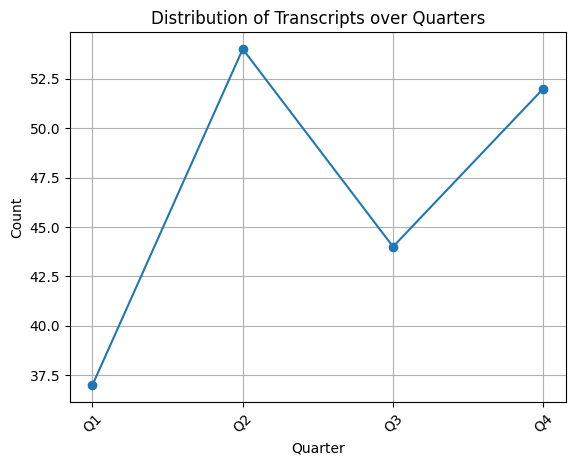

In [35]:
# Count the occurrences of each quarter
quarter_counts = df_clean['Quarter'].value_counts().sort_index()

# Create a line chart
plt.plot(quarter_counts.index, quarter_counts.values, marker='o')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.title('Distribution of Transcripts over Quarters')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

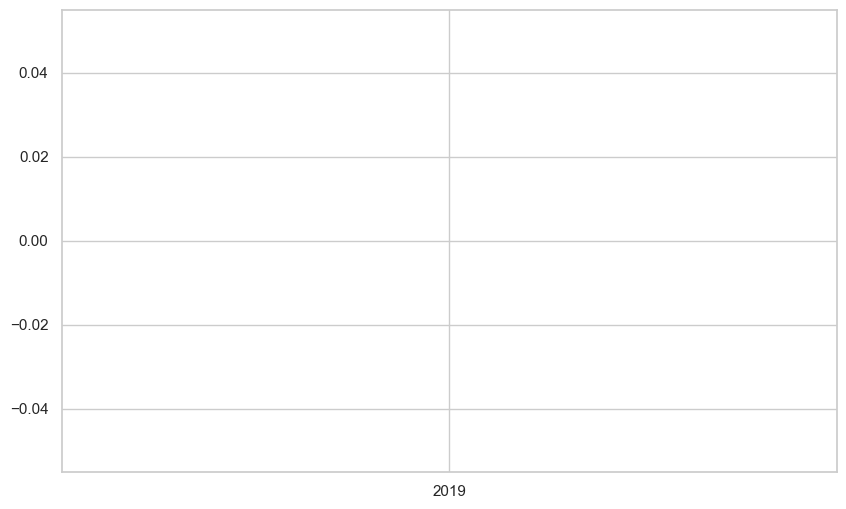

In [42]:
# Count the occurrences of each year
year_counts = df_clean['Year'].value_counts().sort_index()

# Create a line chart using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Transcripts over Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [43]:
df_clean['new_texts'] = None

for i, row in df_clean.iterrows():

  year = row['Year']
  quarter = row['Quarter']
  text = row['transcript_y']

  new_text = [f"Year: {year}", f"Quarter: {quarter}", f"transcript: {text}"]

  df_clean.at[i, 'new_texts'] = new_text

/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/3594869880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['new_texts'] = None


In [44]:
# Add new column
df_clean['label'] = ''

# Condition to check if value is above 0.6
cond = df_clean['Positive'] > 0.6

# Assign labels to new column
df_clean['label'] = np.where(cond, '1', '0')
df_clean['label_N'] = np.where(cond, 'increase', 'decrease')

/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/2579129284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['label'] = ''
/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/2579129284.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['label'] = np.where(cond, '1', '0')
/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/2579129284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [45]:
label_counts = pd.DataFrame(df_clean['label_N'].value_counts())
label_counts

,count
label_N,
increase,97
decrease,90


Here we create an array with the label names in the order they were numerically encoded. We use them later when plotting model performance data.

In [46]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(df_clean['label_N'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

['decrease', 'increase']

In [49]:
pattern = r"[\[\]]"

df_clean['new_texts'] = df_clean['new_texts'].apply(lambda x: re.sub(pattern, '', str(x)))
df_clean['new_texts']

/var/folders/lj/sq_z3m_s3z51_g2s4qfv2hrw0000gn/T/ipykernel_91501/1269960740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['new_texts'] = df_clean['new_texts'].apply(lambda x: re.sub(pattern, '', str(x)))


0      'Year: 2021', 'Quarter: Q2', "transcript: Prepared Remarks:\nOperator\nGood day and thank you fo...
1      'Year: 2021', 'Quarter: Q1', "transcript: Prepared Remarks:\nOperator\nGood day and thank you fo...
2      'Year: 2022', 'Quarter: Q2', "transcript: Prepared Remarks:\nOperator\nExcuse me, everyone. We n...
3      'Year: 2020', 'Quarter: Q4', "transcript: Prepared Remarks:\nSarah Fakih\nThank you. Good mornin...
4      'Year: 2020', 'Quarter: Q3', "transcript: Prepared Remarks:\nOperator\nLadies and gentlemen, tha...
                                                      ...                                                 
183    'Year: 2021', 'Quarter: Q3', "transcript: Prepared Remarks:\nOperator\nGood morning. My name is ...
184    'Year: 2021', 'Quarter: Q2', "transcript: Prepared Remarks:\nKathy MacDonald -- Senior Vice Pres...
185    'Year: 2021', 'Quarter: Q4', "transcript: Prepared Remarks:\nOperator\nGood day, ladies and gent...
186    'Year: 2020', 'Quarter: Q4', "

In [50]:
texts= df_clean['new_texts'].values

In [51]:
labels= df_clean['label'].values

In [56]:
len(texts), labels[0:10]

(187, array(['0', '1', '1', '0', '0', '0', '1', '1', '1', '0'], dtype=object))

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

Original Text:  'Year: 2021', 'Quarter: Q2', "transcript: Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceRe Insurance Second Quarter Earnings Conference Call. Operator Instructions Please be advised that today's conference is being recorded. Operator Instructions\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP, Finance and Investor Relations. Please go ahead.\nKeith McCue -- Senior Vice President, Finance and Investor Relations\nThank you. Good morning. Thank you for joining our first Phonetic quarter financial results conference call.\nYesterday, after the market close, we issued our quarterly release. If you didn't receive a copy, please call me at 441-239-4830 and we'll make sure to provide you with one. There will be an audio replay of the call available from about 1:30 PM Eastern Time today through midnight on August 23. The replay can be accessed by dialing 855-859-2056 US toll free or 1

We then tokenize and encode the entire dataset. In this process, we perform the following:

- tokenize the text as shown above
- encode it to the corresponding numeric values for each token.
- truncate it to the maximum sequence length of 300.
- pad the tokens positions greater than 300.
- include the special token IDs to mark the beginning and end of each sequence.

In [ ]:
text_ids = [tokenizer.encode(text, max_length=512, pad_to_max_length=True) for text in texts]

text_ids[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[101,
 1005,
 2095,
 1024,
 25682,
 1005,
 1010,
 1005,
 4284,
 1024,
 1053,
 2475,
 1005,
 1010,
 1000,
 24051,
 1024,
 4810,
 12629,
 1024,
 1032,
 16780,
 16259,
 1032,
 17895,
 7716,
 2154,
 1998,
 4067,
 2017,
 2005,
 3061,
 2011,
 1012,
 6160,
 2000,
 1996,
 8028,
 2890,
 5427,
 2117,
 4284,
 16565,
 3034,
 2655,
 1012,
 6872,
 8128,
 3531,
 2022,
 9449,
 2008,
 2651,
 1005,
 1055,
 3034,
 2003,
 2108,
 2680,
 1012,
 6872,
 8128,
 1032,
 9152,
 2052,
 2085,
 2066,
 2000,
 2192,
 1996,
 3034,
 2058,
 2000,
 2028,
 1997,
 2115,
 7492,
 2651,
 1010,
 6766,
 23680,
 5657,
 1010,
 17917,
 2361,
 1010,
 5446,
 1998,
 14316,
 4262,
 1012,
 3531,
 2175,
 3805,
 1012,
 1032,
 25930,
 20175,
 2232,
 23680,
 5657,
 1011,
 1011,
 3026,
 3580,
 2343,
 1010,
 5446,
 1998,
 14316,
 4262,
 1032,
 23961,
 4819,
 2243,
 2017,
 1012,
 2204,
 2851,
 1012,
 4067,
 2017,
 2005,
 5241,
 2256,
 2034,
 26664,
 4284,
 3361,
 3463,
 3034,
 2655,
 1012,
 1032,
 6396,
 20367,
 10259,
 1010,
 2044,
 1996,
 30

In [ ]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))

512
512


To fine-tune our model, we need two inputs: one array of token IDs (created above) and one array of a corresponding binary mask, called attention mask in the BERT model specification. Each attention mask has the same length of the corresponding input sequence and has a 0 if the corresponding token is a pad token, or a 1 otherwise.

In [ ]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

att_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Here we split the input and output arrays created before into train, validation, and test sets. We use 80% of the data for training, 10% for training validation, and 10% for final testing.

In [ ]:
train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=111, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=111, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)

We are working with the PyTorch artifacts in the transformers library, therefore we need our model input and output data as PyTorch tensors.

In [ ]:
train_y = train_y.astype(int) # if strings, convert to int
test_y = test_y.astype(int) # if strings, convert to int
val_y  = val_y .astype(int) # if strings, convert to int

In [ ]:
train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([149, 512])
torch.Size([19, 512])
torch.Size([19, 512])
torch.Size([149])
torch.Size([19])
torch.Size([19])
torch.Size([149, 512])
torch.Size([19, 512])
torch.Size([19, 512])


To feed data into the model for training, we use Pytorch’s Dataset, DataLoader, and Sampler. For feeding training data, which drives model weights updates, we use the RandomSampler. For feeding the validation data we can use the SequentialSampler.


In [ ]:
batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
num_labels = len(set(labels))

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT is a very large model. Unless you are freezing model weights in all layers but the classification layer, it is recommended to train it on a GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


Here we print the model architecture and all model learnable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model), '\n', model)

Number of trainable parameters: 66955010 
 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
           

In [ ]:
[n for n, p in model.named_parameters()]

['distilbert.embeddings.word_embeddings.weight',
 'distilbert.embeddings.position_embeddings.weight',
 'distilbert.embeddings.LayerNorm.weight',
 'distilbert.embeddings.LayerNorm.bias',
 'distilbert.transformer.layer.0.attention.q_lin.weight',
 'distilbert.transformer.layer.0.attention.q_lin.bias',
 'distilbert.transformer.layer.0.attention.k_lin.weight',
 'distilbert.transformer.layer.0.attention.k_lin.bias',
 'distilbert.transformer.layer.0.attention.v_lin.weight',
 'distilbert.transformer.layer.0.attention.v_lin.bias',
 'distilbert.transformer.layer.0.attention.out_lin.weight',
 'distilbert.transformer.layer.0.attention.out_lin.bias',
 'distilbert.transformer.layer.0.sa_layer_norm.weight',
 'distilbert.transformer.layer.0.sa_layer_norm.bias',
 'distilbert.transformer.layer.0.ffn.lin1.weight',
 'distilbert.transformer.layer.0.ffn.lin1.bias',
 'distilbert.transformer.layer.0.ffn.lin2.weight',
 'distilbert.transformer.layer.0.ffn.lin2.bias',
 'distilbert.transformer.layer.0.output_laye

In the following 5 cells we define our PyTorch optimizer and corresponding parameters, learning rate scheduler, and the training loop for the fine-tuning procedure. We train for 4 epochs.

In [ ]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 8
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print(next(model.parameters()).device)

cuda:0


In [ ]:
device = torch.device('cuda')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()

    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()

        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)

        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.data / num_mb_train

    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())

    with torch.no_grad():
        model.eval()

        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)

            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)

            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)

            val_loss += loss.data / num_mb_val

        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Train loss after itaration 1: 0.694018
Validation loss after itaration 1: 0.707770
Time: 0m 7s

Train loss after itaration 2: 0.692726
Validation loss after itaration 2: 0.711493
Time: 0m 6s

Train loss after itaration 3: 0.686108
Validation loss after itaration 3: 0.716716
Time: 0m 6s

Train loss after itaration 4: 0.692037
Validation loss after itaration 4: 0.723342
Time: 0m 6s

Train loss after itaration 5: 0.687498
Validation loss after itaration 5: 0.721640
Time: 0m 6s

Train loss after itaration 6: 0.682780
Validation loss after itaration 6: 0.721392
Time: 0m 6s

Train loss after itaration 7: 0.676989
Validation loss after itaration 7: 0.718406
Time: 0m 7s

Train loss after itaration 8: 0.681077
Validation loss after itaration 8: 0.717559
Time: 0m 7s


After training, we can save the model and necessary configuration parameters, to recreate it later and use it to score the test data. Here we also save the losses computed from both training and validation data.

In [ ]:
out_dir = './model'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

In [ ]:
out_dir = './model'

model = DistilBertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

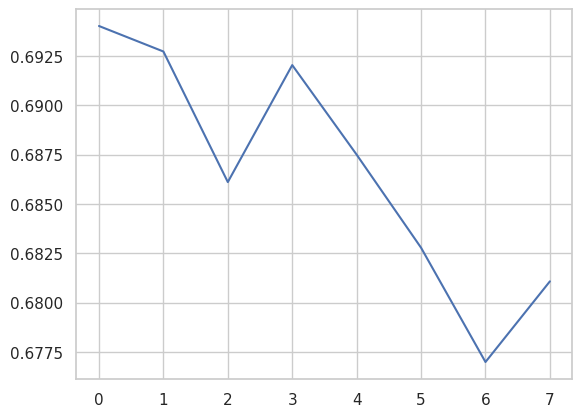

In [ ]:
plt.figure()
plt.plot(train_losses)

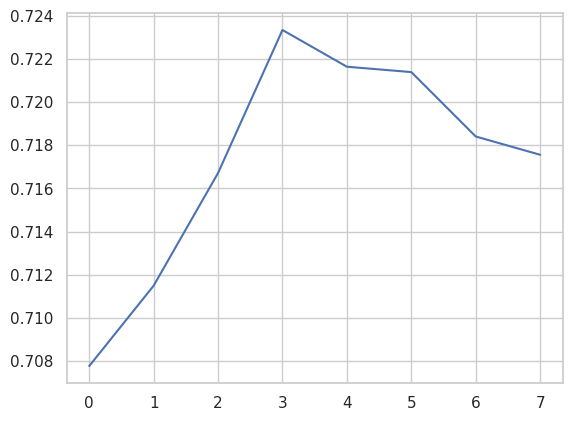

In [ ]:
plt.figure()
plt.plot(val_losses)

After instantiating a trained model, we can then score the test data and compute its accuracy. We then print the classification report and plot a confusion matrix.

The trained model gives us good results on the test data, being able to correctly classify 80% or more on each of the 6 distinct categories.

In [ ]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)

In [ ]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

In [ ]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.6842105263157895


In [ ]:
print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00         6
    increase       0.68      1.00      0.81        13

    accuracy                           0.68        19
   macro avg       0.34      0.50      0.41        19
weighted avg       0.47      0.68      0.56        19



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 0  6]
 [ 0 13]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


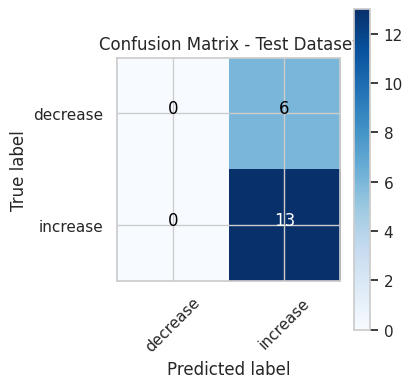

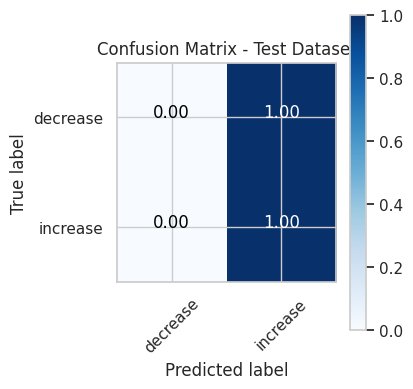

In [ ]:
cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=1)

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(4,4))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

# **Conclusion**

- The model performs reasonably well on this small dataset for the "increase" class, achieving a precision of 0.68, recall of 1.0, and F1 score of 0.81.

- However, it failed to predict any examples of the "decrease" class correctly, achieving a precision, recall, and F1 of 0.0 for that class.

- The overall accuracy on this small test set was 0.68.

- The macro averages, which give equal weight to each class, show there is still room for improvement (macro precision=0.34, recall=0.50, F1=0.41).

- Given the small data size, these results should be taken as preliminary. Further testing on larger, more varied data is needed to properly evaluate the model's performance.

- As a next step, I would recommend retraining the model on a larger dataset and/or trying a different language model architecture besides BERT to see if performance can be improved, especially for the underrepresented "decrease" class.
